This notebook demonstrates how one can use a dedicated tool to _fast_ read data from larcv file and load into a numpy array for network training.
We will use a python interface class called `dataloader2.larcv_threadio` (let's not ask what happened to `dataloader1`).

### Some details (feel free to ignore)
`larcv_threadio` is a mere python API to use `ThreadProcessor`, a multi-threaded `larcv` file reader written in C++.
If you would like to write your own C++ API, you can still use `ThreadProcessor` to write a wrapper API.

In [2]:
from __future__ import print_function

import ROOT
from larcv import larcv
from larcv.dataloader2 import larcv_threadio
import numpy
import matplotlib.pyplot as plt
%matplotlib inline

# instantiate dataloader2
proc = larcv_threadio()

## Configuring larcv_threadio
`larcv_threadio` accepts a simple dictionary with configuration parameters.
There are only 3 parameters:
* `verbosity` ... recommended value=0. When > 0, some status information is printed out into `sys.stdout` stream.
* `filler_cfg` ... necessary! This is acutal meat that configures an internal `larcv` C++ object (`ThreadProcessor`).
* `filler_name` ... necessary! This has to match to the string key of a configuration block inside the `filler_cfg` file. You'll see it in the following. 

### Some details (feel free to ignore)
In case you wonder why you need `filler_name` ... this is because `larcv` configuration file can contain more than one configuration parameter set in one file. This parameter is used to identify which configuration parameter set should be used.

In [3]:
# construct configuration dictionary
filler_cfg={}
filler_cfg["filler_name"] = 'ThreadProcessor'
filler_cfg["verbosity"]   = 0,
filler_cfg['filler_cfg']  = 'configs/example_dataloader.cfg'

proc.configure(filler_cfg)

 setting verbosity 3


Next, let's take a look at the actual configuration file we fed to `filler_cfg`.
### If above cell does not return in a few seconds...
then it is even more important to look at the configuration. One possible issue is crogged text to be printed on the notebook. We have to make sure the `Verbosity` value is set to 3 or larger everywhere.

In [4]:
print(open('configs/example_dataloader.cfg').read())

ThreadProcessor: {
  Verbosity:    3
  NumThreads: 2
  NumBatchStorage: 2
  RandomAccess: true
  InputFiles:   ["../proton.root","../electron.root"]
  ProcessType:  ["BatchFillerImage2D","BatchFillerPIDLabel"]
  ProcessName:  ["image","label"]
  ProcessList: {
    image: {
      Verbosity: 3
      ImageProducer: "data"
      Channels: [2]
      EnableMirror: false
    }
    label: {
      Verbosity: 3
      ParticleProducer: "mctruth"
      PdgClassList: [2212,11]
    }
  }
}



### Whoa...
Yep, there's a lot going on here. I don't recommend you try to understand all of them right now.
In fact, it is a lot easier once you nail `larcv` usage first. I cover minimal portions here since my focus is to get you familiarized with `larcv_threadio` and not "`larcv` in general".

## Minimum details
Remember this is a configuration to enable multi-threaded reading of data. So keep a big picture in mind: the purpose of this file is to tell C++ program how/what to read from `larcv` data file.

### `ThreadProcessor` block
There are 3 levels of configuration parameters. The biggest clause is around `ThreadProcessor`. Note this name is what needed to match to `filler_name` for `larcv_threadio` configuration dictionary. Inside this block, there is a list of parameters covered below.
* `NumThreads` ... positive `int` ... number of threads to instantiate for reading a file
* `NumBatchStorage` ... positive `int` ... number of a `batch` data buffer storage. Each storage is filled by a dedicated thread. So it makes sense to set this equal or larger than `NumThreads`.
* `RandomAccess` ... `true/false` ... randomizes an order of data (event) to be accessed in the file(s)
* `InputFiles` ... `string` array ... a list of input `larcv` files you want the reader to use. The order does not matter if `RandomAccess` is `true`.
* `ProcessType` ... `string` array ... a list of `larcv` C++ modules (C++ class names) to be run in respective order. `BatchFillerImage2D` takes input 2D image data. `BatchFillerPIDLabel` takes input simulation information and generate a particle label based on [PDG code](http://pdg.lbl.gov/2007/reviews/montecarlorpp.pdf).
* `ProcessName` ... `string` array ... a list of unique string names for declared `larcv` modules in `ProcessType` argument. This is used to look up a module-specific configuration parameters (see below).
* `ProcessList` ... configuration block ... see next section :)

### `ProcessList` block
This block contains a list of `larcv` module configuration parameter sets with a module's unique name as a key. Here, we see `image` for `BatchFillerImage2D` module and `label` for `BatchFillerPIDLabel`. 

### `image` block
This block configures `BatchFillerImage2D` which reads in input image data.
* `ImageProducer` ... `string` ... this is a label to identify which 2D image data product from the input file to read. 
* `Channels` ... positive `int` array ... 2D image data has multiple channels, and this parameter specifies which channel(s) to read. Here, we will use only channel 2.
* `EnableMirror` ... `true/false` ... when set to `true`, input data is randomly flipped with respect to the center vertical axis (left/right mirroring). This is one of the most simple data augmentation technique.

### `label` block
This block configures `BatchFillerPIDLabel` which defines a single classification label 2d image read by `BatchFillerImage2D` using simulation information.
* `ParticleProducer` ... `string` ... this is a label to identify which "simulation information" should be used.
* `PdgClassList` ... signed `int` array ... this lists [PDG code](http://pdg.lbl.gov/2007/reviews/montecarlorpp.pdf), a unique identifier of a particle type to define a set of classification target. Here, `2212` and `11` correspond to proton and electron respectively. The index of PDG code is typically used as a classification label. In this example, proton has label 0 as its index is 0.


## Let's run!
Too much text! Let's run `larcv_threadio` to read in some data!
First, we issue the command to start the multi-threaded data read.

In [5]:
proc.start_manager(10)

where the argument is number of data segments (events, or images) to read and store into 1 buffer = 1 `batch`. Once `start_manager` command is issued, all active threads go find an available storage buffer to fill them. Remember you specified number of threads and storage buffers by `NumThreads` and `NumBatchStorage` configuration parameters.

The next command moves the data stored in the buffer into a `numpy` array so that we can access in python.

In [6]:
proc.next()

## How to "fetch" a `batch` data
In order to access the stored batch data, simply call `larcv_threadio.fetch_data` function (below). Here, you should give an argument `string` that is the name of `larcv` module responsible for reading data for you. Let's fetch an image data.

In [7]:
data = proc.fetch_data('image')
print(type(data))

<class 'larcv.dataloader2.batch_pydata'>


as you can see, the return of `fetch_data` is `batch_pydata` which holds two information about data: the `numpy` array of data itself and its dimension. You can access them like:

In [8]:
image_data = data.data()
dim_data   = data.dim()

print('numpy data shape',image_data.shape,'... full shape info:', dim_data)


numpy data shape (10, 65536) ... full shape info: [ 10 256 256   1]


Data is stored in `image_data` in the form of `(10,65536)`, which is 10 batch of data. `dim_data` is the full data dimension: `[10,256,256,1]` means this is "10 batch data of 256x256x1 image". You can see it is 2D image with 1 channel. Note `256*256*1 = 65536`. We can visualize an image using a simple imshow.

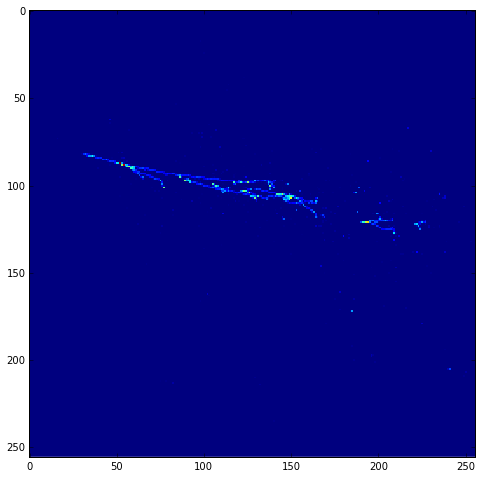

In [9]:
image_reshaped = image_data.reshape(dim_data[:-1])
fig,ax = plt.subplots(figsize=(8,8))
plt.imshow(image_reshaped[0],cmap='jet',interpolation='none')
plt.show()

## Labels?
Yep, we should also have data filled by `BatchFillerPIDLabel`. Remember how to fetch?

In [10]:
label = proc.fetch_data('label')
label_data = label.data()
dim_label  = label.dim()

print('numpy data shape',label_data.shape,'... full shape info:', dim_label)

numpy data shape (10, 2) ... full shape info: [10  2]


Since we defined labels with only 2 particles, the dimension is quite simple: `(10,2)`. With this size, you can simply print them out to check the content, right?

In [11]:
print(label_data)

[[ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]]


So we know the 1st image is an electron because we defined `PdgClassList: [2212,11]` in the configuration and the label for the entry 0 is `[0,1]`. Looks like we can find a proton in the next image :)

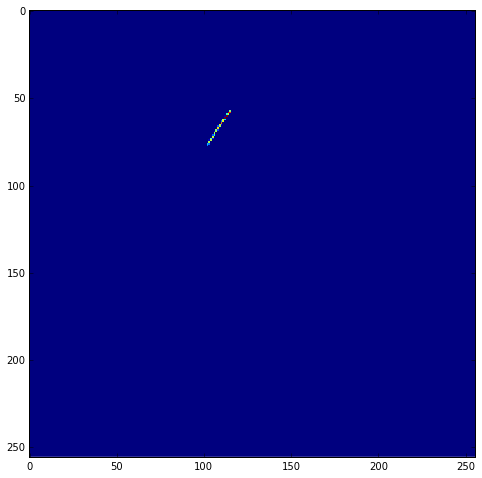

In [13]:
fig,ax = plt.subplots(figsize=(8,8))
plt.imshow(image_reshaped[1],cmap='jet',interpolation='none')
plt.show()

## Next batch!
How to get the next buffer storage? Quite simple:

In [14]:
proc.next()
label = proc.fetch_data('label')
print(label.data())

[[ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]]


## What happened to the last batch?
It is gone :( So how did this happen? 

To answer this, it's important to emphasize the term "available" storage buffer. Earlier we learned that threads read from file and fill data into an available storage buffer. What does "available" mean? That means storage buffer that is either empty (initial state) OR ready to be refilled. This is sometimes called consumer-producer model. A user (you) is a consumer here, and `next` function flags previously accessed data is `already consumed`, and make that buffer as the next "available" storage buffer. 

# Questions?
This completes the *quick-start* tutorial of `larcv_threadio`. Hope this helped for you to understand how this is working when used in our training example notebook.